# Adam from Scratch

In this notebook I want to dive into verifying and applying my adam implementation. Similar to what I've done with other reimplementations, I want to 
- compare with PyTorch's native adam optim
- visualize how my adam is optimizing compared to other optimizers

I'll start with setting up the imports and paths.

In [9]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # adam/ is up one level

And next I can do the imports.

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from adam.optimizer import Adam

I'm going to add a seed in the beginning instead of having to do it later.

In [11]:
torch.manual_seed(42)

Now it's time to actually train a model. Usually adam is used in deep learning but I wanted to start with using it with a simple linear regression model.

I am going to make a super simple function (`y = 3x + 2`).

In [12]:
x = torch.randn(200, 1)
y = 3 * x + 2 + 0.1 * torch.randn_like(x)

Above, we created a synthetic dataset for the linear function defined above but we're adding a bit of random noise so it's more realistic. 

`x` is a tensor of dimension 200x1 and contains values (0, 1) *normally ditributed*. 

y = `3x+2` + small random noise scaled by 0.1 to each datapoint

`torch.randn_like(x)` creates a new tensor of the same shape as x but filled with random values from a standard normal distribution. Essentially we are creating another `torch.randn` but borrowing the size from a previous tensor that we have (`x`).

Let's train with our implementation of Adam.

In [14]:
w = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, 1, requires_grad=True)
opt = Adam([w, b], lr=0.05)

losses = []

for _ in range(200):
    pred = x @ w + b
    loss = ((pred - y) ** 2).mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

I've saved logs to `losses`. Before we visualize, let's train with PyTorch's Adam.

In [15]:
w_torch = torch.randn(1, 1, requires_grad=True)
b_torch = torch.randn(1, 1, requires_grad=True)
torch_opt = torch.optim.Adam([w_torch, b_torch], lr=0.05)

torch_losses = []

for _ in range(200):
    pred = x @ w_torch + b_torch
    loss = ((pred - y) ** 2).mean()
    loss.backward()
    torch_opt.step()
    torch_opt.zero_grad()
    torch_losses.append(loss.item())

And now we have losses as logs in `losses` and `torch_losses`. We can compare them now.

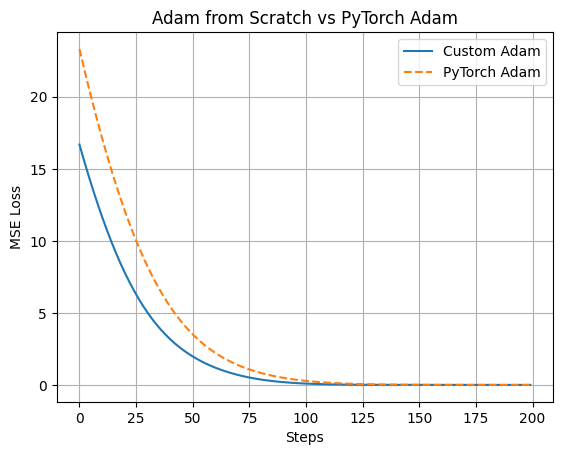

In [16]:
plt.plot(losses, label="Custom Adam")
plt.plot(torch_losses, label="PyTorch Adam", linestyle='--')
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Adam from Scratch vs PyTorch Adam")
plt.grid(True)
plt.show()

In [17]:
print(f"Our Adam:     w = {w.item():.4f}, b = {b.item():.4f}")
print(f"PyTorch Adam: w = {w_torch.item():.4f}, b = {b_torch.item():.4f}")

Our Adam:     w = 3.0058, b = 2.0128
PyTorch Adam: w = 3.0053, b = 2.0069


That looks pretty good in my opinion. From the image we can see that our Adam implementation converges slightly faster but PyTorch's implementation ends up at a closer answer, which makes sense. They probably use some other fused operations or stability forcing techniques that our vanilla implementation doesn't have.

For being 0.0005 away on `w` and 0.0059 away on `b`, I would say this is pretty good.

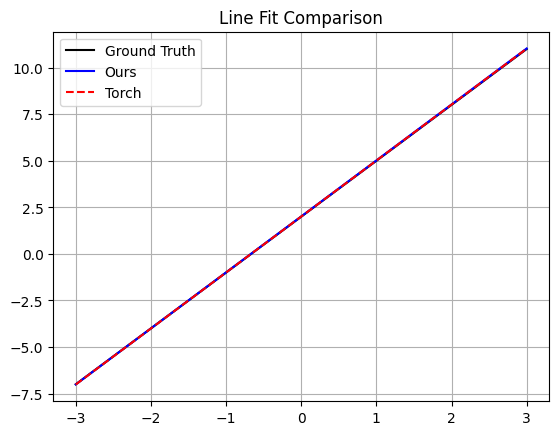

In [18]:
x_test = torch.linspace(-3, 3, 100).view(-1, 1)
y_true = 3 * x_test + 2
y_pred_ours = x_test @ w + b
y_pred_torch = x_test @ w_torch + b_torch

plt.plot(x_test, y_true, label="Ground Truth", color='black')
plt.plot(x_test, y_pred_ours.detach(), label="Ours", color='blue')
plt.plot(x_test, y_pred_torch.detach(), label="Torch", color='red', linestyle='--')
plt.legend()
plt.title("Line Fit Comparison")
plt.grid(True)
plt.show()

Visually, the ground truth function, our model with our own adam, and our model with PyTorch's adam all look super similar (basically overlapping on the graph).

I'm pretty confident that our Adam is working well now. I want to push it a little further and try it on a simple 2 layer MLP like XOR.

Here's how the architecture would look like:

```txt
Input (2) → Hidden layer (4 units, non-linear) → Output (1 unit with sigmoid)
```

This means 2 layers in total: 1 hidden layer (Linear + ReLU) and 1 output layer (Linear + Sigmoid).

In [19]:
import torch
from adam.optimizer import Adam

# XOR data
X = torch.tensor([[0.,0.],[0.,1.],[1.,0.],[1.,1.]])
Y = torch.tensor([[0.],[1.],[1.],[0.]])

model = torch.nn.Sequential(
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1),
    torch.nn.Sigmoid()
)

optimizer = Adam(model.parameters(), lr=0.1)

for epoch in range(10000):
    y_pred = model(X)
    loss = torch.nn.functional.binary_cross_entropy(y_pred, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6707
Epoch 1000, Loss: 0.0001
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000
Epoch 5000, Loss: 0.0000
Epoch 6000, Loss: 0.0000
Epoch 7000, Loss: 0.0000
Epoch 8000, Loss: 0.0000
Epoch 9000, Loss: 0.0000


Maybe 9000 epochs was overkill. Anyways, we would know that our Adam definitely is working if we feed in the 4 unique types of data for XOR.

In [20]:
print("\nFinal predictions:")
with torch.no_grad():
    for i in range(4):
        x_input = X[i]
        pred = model(x_input).item()
        print(f"Input: {x_input.tolist()} → Predicted: {pred:.4f}")


Final predictions:
Input: [0.0, 0.0] → Predicted: 0.0000
Input: [0.0, 1.0] → Predicted: 1.0000
Input: [1.0, 0.0] → Predicted: 1.0000
Input: [1.0, 1.0] → Predicted: 0.0000


Our model successfully learned XOR with Adam!